# Classification. Linear models and KNN

In [228]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [229]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from seaborn import heatmap

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


1) Для сохранения сабмита по Титанику можно сделать что-нибудь like this:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)


В ячейке markdown можно реализовать кнопку для скачивания сабмита:
<a href="./my_submission.csv"> Download File </a>

Либо скачать через стандартные инструменты (изменено)
Titanic - Machine Learning from Disaster
Start here! Predict survival on the Titanic and get familiar with ML basics

Porto Seguro’s Safe Driver Prediction
Predict if a driver will file an insurance claim next year.

2) Column Transformer with Mixed Types
https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
    
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html



Объеденяю данные train.csv и test.csv в одну таблицу, чтобы унифицировать процедуру предварительной обработки данных.  Преобразованиие колонки данных Pclass в тип str облегчает последующую работу с categorical_features.

In [230]:
train_data = pd.read_csv("data/titanic/train.csv").set_index('PassengerId')
train_data['Pclass_old'] = train_data['Pclass']
train_data['Pclass'] = train_data['Pclass'].astype(str)
train_data['type'] = 'train'

test_data = pd.read_csv('data/titanic/test.csv').set_index('PassengerId')
test_data['Pclass_old'] = test_data['Pclass']
test_data['Pclass'] = test_data['Pclass'].astype(str)
test_data['type'] = 'test'

data = pd.concat([train_data, test_data])

In [231]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_old,type
PassengerId,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3,train
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,train
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,train
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,train
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,3,test
1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1,test
1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,3,test


In [232]:
data.nunique()

Survived         2
Pclass           3
Name          1307
Sex              2
Age             98
SibSp            7
Parch            8
Ticket         929
Fare           281
Cabin          186
Embarked         3
Pclass_old       3
type             2
dtype: int64

In [233]:
categorical_features = ['Sex', 'Embarked', 'Cabin', 'Pclass', 'SibSp', 'Parch']
numerical_features = ['Age', 'Fare']

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [234]:
# count male and female
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [235]:
# survived passengers, devided by male and female
train_data.groupby("Sex")["Survived"].value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

In [236]:
train_data.groupby("Sex")["Survived"].mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

На основании имеющихся данных процент выживших женщин 74% намного превышает процент выживших мужчин 19%, что говорит о более высокой стрессоустойчивости девушек:) 
Скорее всего, из-за высокого уровня осознанности пассажиров и членов экипажа Титаника, спасали в первую очередь женщин и детей.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

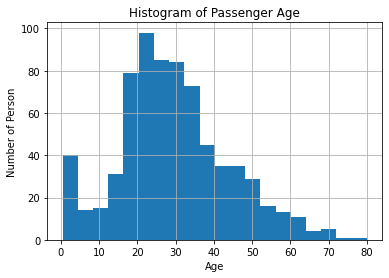

In [237]:
# age distribution of the passenger
train_data.Age.hist(bins=20)
plt.xlabel("Age")
plt.ylabel("Number of Person")
plt.title("Histogram of Passenger Age");

In [238]:
# the average age of survived  passengers
survivors_data = train_data[train_data.Survived==True]
survivors_data.Age.mean()

28.343689655172415

In [239]:
# the median age of survived passengers
survivors_data.Age.median()

28.0

In [240]:
# the average age of deceased passengers
deceased_data = train_data[train_data.Survived==False]
deceased_data.Age.mean()

30.62617924528302

In [241]:
# the median age of deceased passengers
deceased_data.Age.median()

28.0

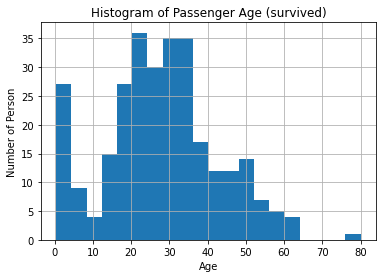

In [242]:
# age distribution of the survived passenger
survivors_data.Age.hist(bins=20)
plt.xlabel("Age")
plt.ylabel("Number of Person")
plt.title("Histogram of Passenger Age (survived)");

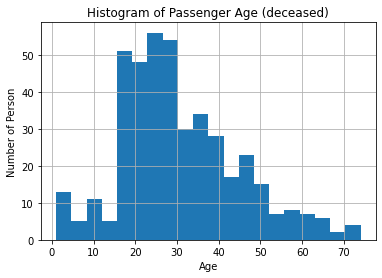

In [243]:
# age distribution of the deceased passenger
deceased_data.Age.hist(bins=20)
plt.xlabel("Age")
plt.ylabel("Number of Person")
plt.title("Histogram of Passenger Age (deceased)");

< При спасении пассажиров Титаника, уделяли большое внимание спасению женщин, детей и людей старшего возраста, что говорит об  организованности процесса спасения в очень сложных условиях>

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

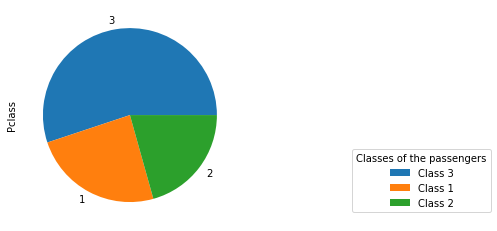

In [244]:
Picture_pclass = train_data.Pclass.value_counts().plot.pie().legend(labels=["Class 3","Class 1","Class 2"],
                                                         loc='center left', 
                                                         bbox_to_anchor=(1.5, 0.2)).set_title("Classes of the passengers")

Наибольшее коллиество пассажиров приходится на третий класс (больше, чем на первый и второй вместе взятые)

Text(0.5, 1.0, 'Percentage of people survived on the different classes(train_data)')

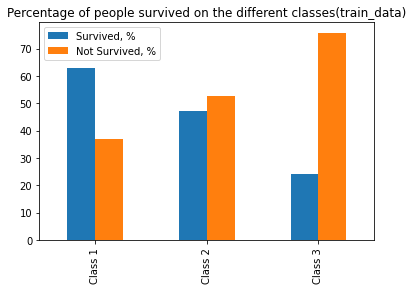

In [245]:
pclass_1_surved = round((train_data[train_data.Pclass_old == 1].Survived == 1).value_counts()[1]/len(train_data[train_data.Pclass_old == 1]) * 100, 2)
pclass_2_surved = round((train_data[train_data.Pclass_old == 2].Survived == 1).value_counts()[1]/len(train_data[train_data.Pclass_old == 2]) * 100, 2)
pclass_3_surved = round((train_data[train_data.Pclass_old == 3].Survived == 1).value_counts()[1]/len(train_data[train_data.Pclass_old == 3]) * 100, 2)
pclass_perc = pd.DataFrame(
    { "Survived, %":{"Class 1": pclass_1_surved,"Class 2": pclass_2_surved, "Class 3": pclass_3_surved},  
     "Not Survived, %":{"Class 1": 100-pclass_1_surved,"Class 2": 100-pclass_2_surved, "Class 3": 100-pclass_3_surved}})
pclass_perc.plot.bar().set_title("Percentage of people survived on the different classes(train_data)")

Из диаграммы видно, что, из пассажиров разных классов, наибольший процент выживших приходится на первый класс

Text(0.5, 1.0, 'Percentage of people survived based on embarking point(train_data)')

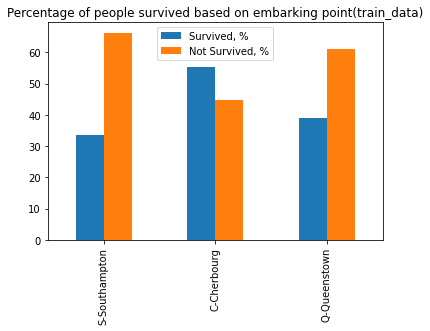

In [246]:
embarked_S_surved = round((train_data[train_data.Embarked == 'S'].Survived == 1).value_counts()[1]/len(train_data[train_data.Embarked == 'S']) * 100, 2)
embarked_C_surved = round((train_data[train_data.Embarked == 'C'].Survived == 1).value_counts()[1]/len(train_data[train_data.Embarked == 'C']) * 100, 2)
embarked_Q_surved = round((train_data[train_data.Embarked == 'Q'].Survived == 1).value_counts()[1]/len(train_data[train_data.Embarked == 'Q']) * 100, 2)
embarked_data = pd.DataFrame(
    { "Survived, %":{"S-Southampton": embarked_S_surved,"C-Cherbourg": embarked_C_surved, "Q-Queenstown": embarked_Q_surved},  
     "Not Survived, %":{"S-Southampton": 100-embarked_S_surved,"C-Cherbourg": 100-embarked_C_surved, "Q-Queenstown": 100-embarked_Q_surved}})
embarked_data.plot.bar().set_title("Percentage of people survived based on embarking point(train_data)")

Из диаграммы видно, что, из пассажиров, севших в разных портах, наибольший процент выживших приходится на Cherbourg

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [247]:
from tabulate import tabulate

top = 10
print(tabulate(
    sorted(list(zip(data.columns, data.isnull().sum(), data.isnull().sum() / data.shape[0] * 100)), key=lambda x: -x[2])[:top], 
    headers=['col_name', 'null_cnt', 'null_perc']))

col_name      null_cnt    null_perc
----------  ----------  -----------
Cabin             1014   77.4637
Survived           418   31.9328
Age                263   20.0917
Embarked             2    0.152788
Fare                 1    0.0763942
Pclass               0    0
Name                 0    0
Sex                  0    0
SibSp                0    0
Parch                0    0


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Приняли решение провести следующие изменения недостающих данных: 

'Age': data['Age'].mean(),
'Cabin': 'no_info',
'Embarked': 'no_info',
'Fare': data['Fare'].mean()

Score от caggle должно проверить правильность принятх решений.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [248]:
y_train = data[data['type'] == 'train']['Survived']

In [249]:
filled_na_data = data.fillna({'Age': data['Age'].mean(),
                              'Cabin': 'no_info',
                              'Embarked': 'no_info',
                              'Fare': data['Fare'].mean()})

In [250]:
data_categorical_ohe = pd.get_dummies(filled_na_data[categorical_features])

X = np.concatenate((data_categorical_ohe.values, filled_na_data[numerical_features].values), axis=1)

In [251]:
X_train, X_test = X[data['type'] == 'train'], X[data['type'] == 'test']

********************  LogisticRegression *****************************

In [252]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [253]:
print('Train score LogisticRegression is %.2f' % accuracy_score(lr.predict(X_train), y_train))

Train score LogisticRegression is 0.84


<AxesSubplot:>

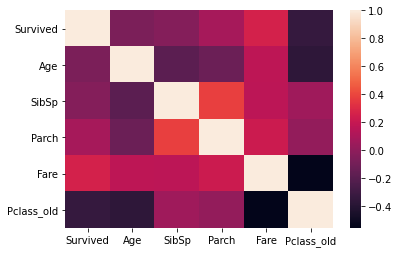

In [254]:
sns.heatmap(filled_na_data.corr())

The cross validated score for LogisticRegression  is: 80.81


Text(0.5, 1.05, 'Confusion_matrix for LogisticRegression')

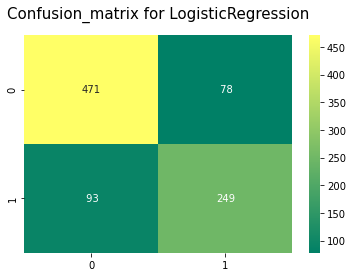

In [255]:
result_rf=cross_val_score(lr,X_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for LogisticRegression  is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(lr,X_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for LogisticRegression', y=1.05, size=15)

test_data = pd.read_csv('data/titanic/test.csv')
test_data.head()

In [256]:
test_preds = lr.predict(X_test)

In [257]:
test_data['Survived'] = test_preds.astype(int)

In [258]:
test_data['Survived'].to_csv('data/titanic/predictions.csv', index_label='PassengerId')

********************  KNN (K-Nearest Neighbors) *****************************

In [259]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=7)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [260]:
print('Train score knn is %.2f' % accuracy_score(knn.predict(X_train), y_train))

Train score knn is 0.79


In [261]:
test_preds_knn = knn.predict(X_test)
test_data['Survived'] = test_preds_knn.astype(int)
test_preds_knn

array([0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0.

In [262]:
test_data['Survived'].to_csv('data/titanic/predictions.csv', index_label='PassengerId')

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Результаты анализа влияния различных параметров данных и их комбинаций на Score from caggle приведены ниже:

Score from kaggle - LogisticRegression (удалось улучшить с 0,76315 до 0,76555). Мой ник на caggle - LeonidKurch
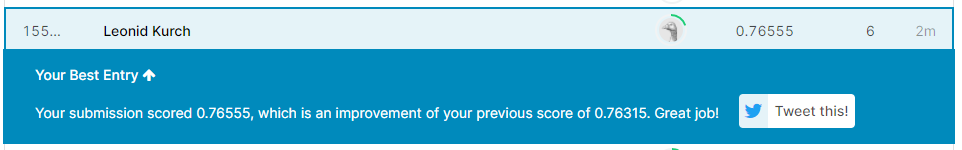

Score from kaggle - knn (удалось улучшить только с 0,6555 до 0,66507)


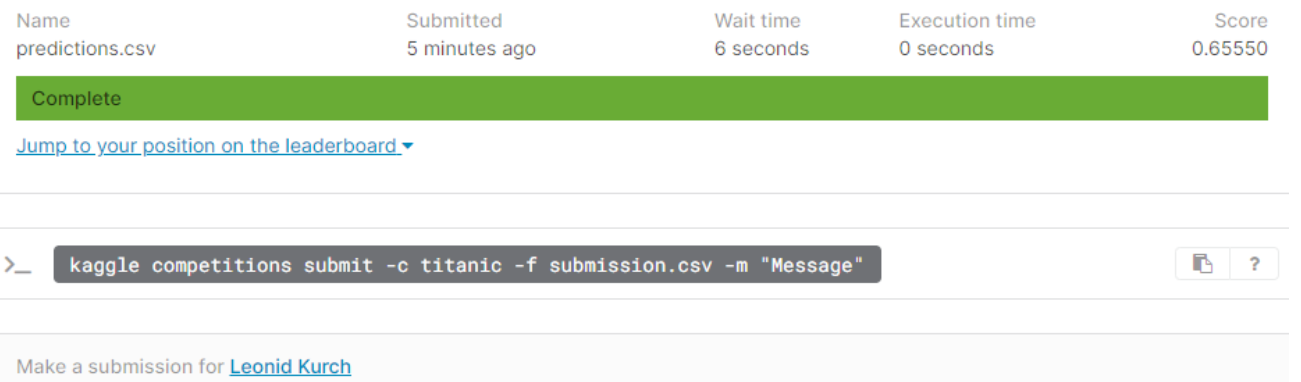

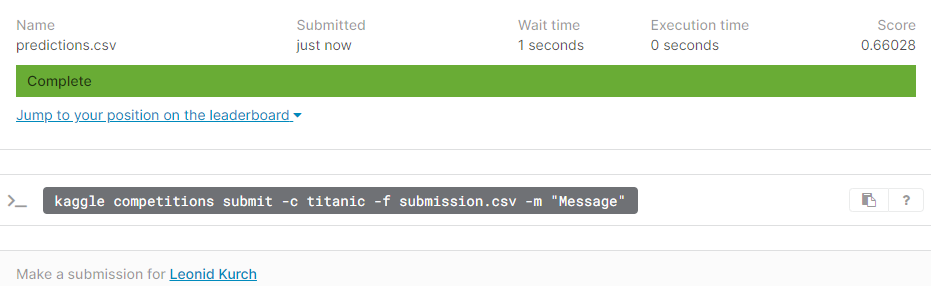

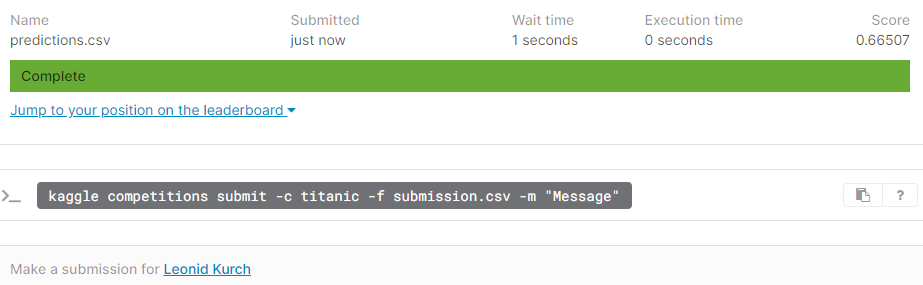

В Ы В О Д: проверка модели на тесте kaggle дала лучшие результаты для LogisticRegression f(score) = 0,76555 !!!
по сравнению с knn f(score) = 0,66507

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [14]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [15]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [16]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [17]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [20]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

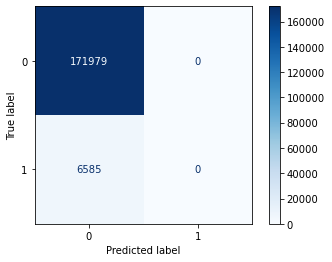

In [21]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [22]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

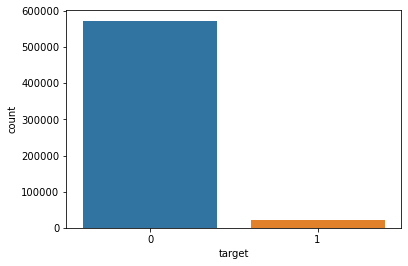

In [23]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [24]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [25]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [26]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [27]:
## your code